# big data mart dataset

## 1. setting modules

In [1]:
# load modules
import numpy as np
import pandas as pd
import geopandas as gpd
import tqdm
import random
import os
import fiona
import sqlite3
from shapely import wkb
from pyproj import Proj, transform
import csv
import chardet

# split
from sklearn.model_selection import train_test_split

# models 
from xgboost import XGBRegressor, DMatrix
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from supervised.automl import AutoML

# tuning
import optuna

# vif
from statsmodels.stats.outliers_influence import variance_inflation_factor

# visualization
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
import plotly
from shapely.geometry import MultiPolygon
from shapely.wkt import loads

# metrics
from sklearn.metrics import mean_squared_log_error

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# test
import scipy.stats as stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
plt.rcParams['font.family'] = 'NanumSquare'
plt.rcParams['font.size'] = 12

In [3]:
# load gpd data
#traffic_by_time = gpd.read_file('../Data/external_open/교통데이터_시간대별_100.gpkg')
#tube = gpd.read_file('../Data/external_open/subway_100.gpkg')
#pkcar = gpd.read_file('../Data/external_open/노상주차_100.gpkg')
ped = gpd.read_file('../Data/external_open/횡단보도_100.gpkg')

In [4]:
ped

,id,count,geometry
0,349,NaN,"MULTIPOLYGON (((1077102.303 1745692.817, 10771..."
1,350,NaN,"MULTIPOLYGON (((1077057.173 1745639.546, 10770..."
2,351,NaN,"MULTIPOLYGON (((1077051.871 1745538.189, 10770..."
3,352,NaN,"MULTIPOLYGON (((1077049.547 1745487.411, 10771..."
4,353,NaN,"MULTIPOLYGON (((1077044.105 1745368.495, 10770..."
...,...,...,...
89311,168686,NaN,"MULTIPOLYGON (((1113905.212 1766486.883, 11138..."
89312,168687,NaN,"MULTIPOLYGON (((1113847.421 1766386.670, 11138..."
89313,168688,NaN,"MULTIPOLYGON (((1113852.491 1766284.918, 11138..."
89314,168701,NaN,"MULTIPOLYGON (((1113842.714 1764974.150, 11138..."


In [4]:
# load pd data
cross = pd.read_csv('../Data/cross100_address.csv', encoding='cp949')
park_cctv = pd.read_csv('../Data/bigdatamart/주차단속카메라정보.csv', encoding='cp949')
rest = pd.read_csv('../Data/bigdatamart/소상공인시장진흥공단_상가(상권)정보_대구_202109.csv')
corner = pd.read_csv('../Data/bigdatamart/먹거리골목업소정보.csv', encoding = 'cp949')
nadel = pd.read_csv('../Data/bigdatamart/소상공인시장진흥공단_전국 나들가게 현황(CSV)_20210512.csv', encoding = 'cp949')
baek = pd.read_csv('../Data/bigdatamart/소상공인시장진흥공단_전국 백년가게 현황_20220713.csv', encoding='cp949')
train = pd.read_csv('../Data/train_3.csv', encoding='cp949')
test = pd.read_csv('../Data/test_3.csv', encoding='cp949')

In [5]:
# random seed 고정하기
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [6]:
# 주소 나누기
park_cctv[['시', '군구', '동가', '주소1', '주소2', '주소3']] = park_cctv['_PARCEL_AD'].str.split(' ', expand=True)

In [7]:
# count
pkc = park_cctv['동가'].value_counts().reset_index()
pkc.columns = ['동가', '주차장CCTV개수']

In [8]:
# 주소 나누기
rest[['시', '군구', '동가', '주소1', '주소2']] = rest['지번주소'].str.split(' ', expand = True)

In [9]:
# 대분류 코드로 나눈 상권, total
rst = pd.crosstab(rest['동가'], rest['상권업종대분류명']).reset_index()
rst['상권total'] = rest['동가'].value_counts().sort_index().reset_index()['count']

In [10]:
# count 한번에 진행하기
cn = corner['주소'].str.split('(', expand = True)[1].str.split(')', expand = True)[0].value_counts().reset_index()
cn.columns = ['동가', '맛집개수']

In [11]:
# 횡단보도 수, 노면주차면수
ped_cross = pd.merge(cross, ped, how = 'outer', on = 'id')
ped_cross.columns = ['id', 'distance', '구군', '동가', '횡단보도개수', 'geometry']

ped_cross_pkcar = pd.merge(ped_cross, pkcar, how = 'outer', on = 'id')
ped_cross_pkcar.columns = ['id', 'distance', '구군', '동가', '횡단보도개수', 'geometry_x', '노상주차면수',
       'PRK_LVL_count_1', 'PRK_LVL_count_2', 'PRK_LVL_count_3',
       'PRK_PAY_YN_count_0', 'PRK_PAY_YN_count_1', 'PRK_PAY_YN_count_2',
       'geometry_y']

In [12]:
# 데이터 합쳐놓기
cross_data = ped_cross_pkcar[['동가', '노상주차면수', '횡단보도개수']].fillna(0).groupby('동가').sum().reset_index().iloc[1:, :]

In [13]:
# 데이터 merge
m1 = pd.merge(pkc, rst, on = '동가', how='outer')
m2 = pd.merge(m1, cn, on = '동가', how='outer')
m3 = pd.merge(m2, cross_data, on = '동가', how = 'outer')
m4 = m3.fillna(0)
m4[m4.columns.difference(['동가'])] = m4[m4.columns.difference(['동가'])].astype(int)

In [14]:
# test에 없는 train 불러오기
train.columns[train.columns.isin(test.columns) == False]

Index(['사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO'],
      dtype='object')

In [15]:
test.columns

Index(['ID', '사고일시', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '시군구', '보행노인사고사고건수',
       '보행노인사고사망자수',
       ...
       '화학', '구조', '구급', '기타', '안전센터', '구조대', '지역대', '먹거리골목업소정보_개수',
       '노인요양시설_개수', '경로당현황_개수'],
      dtype='object', length=108)

In [16]:
# write csv
m4.to_csv('../Data/bigdatamart/merge_3_data_by_dongga.csv', encoding = 'cp949')

### 2. Time Series ECLO

In [17]:
# 시계열 확인 데이터 만들기
t = train.groupby('사고일시')['ECLO'].mean().reset_index()

(array([17897., 18017., 18140., 18262., 18383., 18506., 18628., 18748.,
        18871., 18993.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18017.0, 0, '2019-05'),
  Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01')])

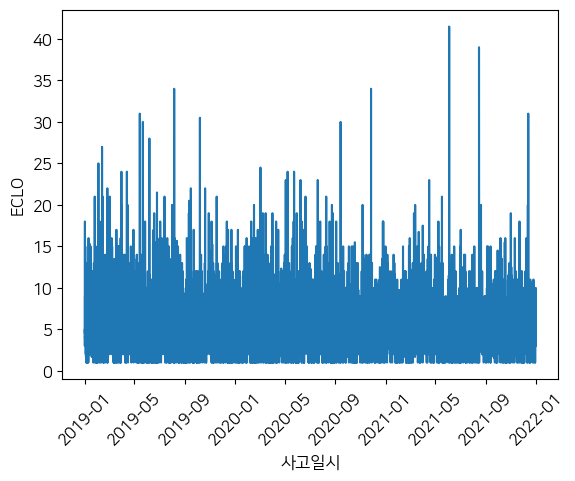

In [20]:
# 시계열로 확인해보기
sns.lineplot(data = t, x = '사고일시', y = 'ECLO')
plt.xticks(rotation = 45)

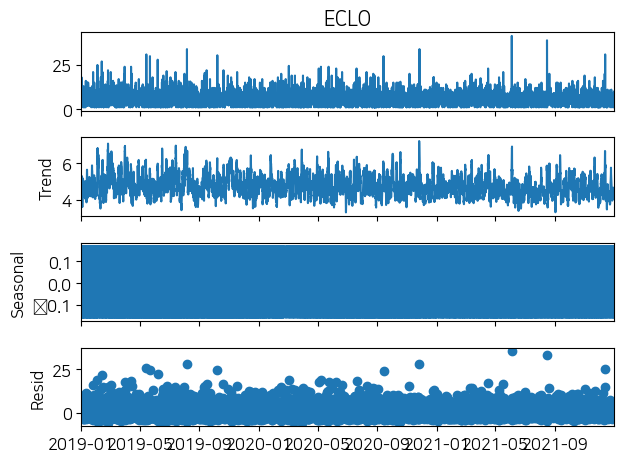

In [19]:
# '사고일시' 열을 datetime 형식으로 변환
t['사고일시'] = pd.to_datetime(t['사고일시'])

# '사고일시' 열을 인덱스로 설정
t.set_index('사고일시', inplace=True)

# 시계열 분해하기
result = seasonal_decompose(t['ECLO'], model='additive', period=24)

# 결과 시각화
result.plot()
plt.show()

### 3. Correlation heatmap

In [33]:
# 범주형 변수 제외하고 상관관계 그려보기 -> 너무 커서 잘 모르겠지만 관계식이 존재하는 것도 보임
correlation_matrix = train[train.dtypes[train.dtypes != 'object'].index].corr()

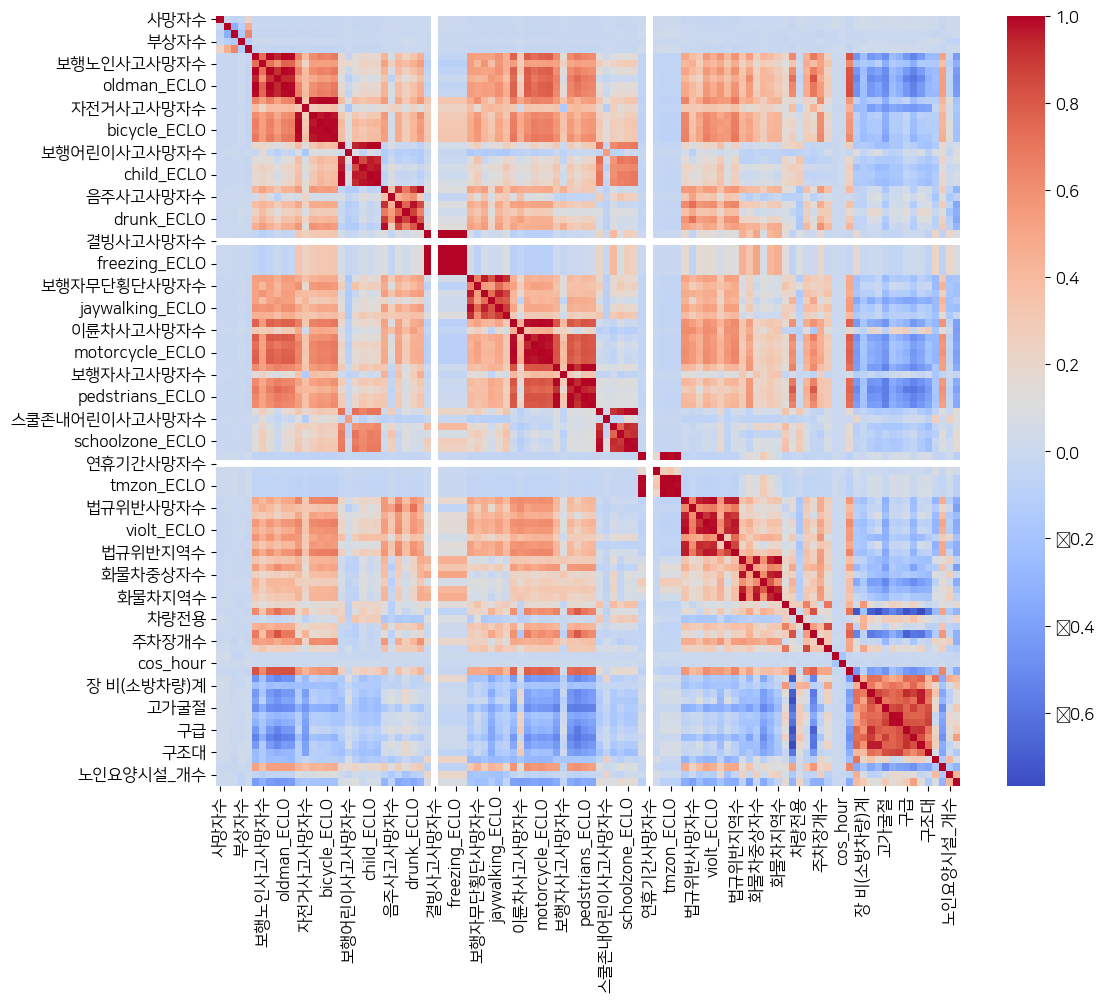

In [36]:
# 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

### 4. Calculate VIF

In [42]:
# 결측치 0으로 만들고 VIF산출을 위한 데이터 생성
tmp = train[train.dtypes[train.dtypes != 'object'].index].fillna(0)

In [49]:
# VIF 출력을 위한 데이터 프레임 형성
vif = pd.DataFrame()

# VIF 값과 각 Feature 이름에 대해 설정
vif["VIF Factor"] = [variance_inflation_factor(tmp.values, i) for i in range(tmp.shape[1])]
vif["features"] = tmp.columns 

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')

In [48]:
# 다중공선성 10 넘어가는 변수의 개수
len(vif[vif['VIF Factor'] > 10])

99

In [67]:
# 시군구 분리해서 넣어두기
train[['시', '군구', '동가']] = train['시군구'].str.split(' ', expand = True)
test[['시', '군구', '동가']] = test['시군구'].str.split(' ', expand = True)

In [70]:
# 열 붙여넣기
train_4 = pd.merge(train, m4, on = '동가', how = 'left').fillna(0)
test_4 = pd.merge(test, m4, on = '동가', how = 'left').fillna(0)

In [71]:
# 저장
train_4.to_csv('train_4.csv', index = False, encoding = 'cp949')
test_4.to_csv('test_4.csv', index = False, encoding = 'cp949')